<table>
    <tr>
        <td><img src="https://user-images.githubusercontent.com/73366653/97095321-45e05a00-165e-11eb-9c60-b90723caba4a.png"                  width="150">
        </td>
        <td><img src="https://user-images.githubusercontent.com/73366653/97095369-b8513a00-165e-11eb-9ef2-e2fcef626f88.jpeg"                width="150">
        </td>
        <td><img src="https://user-images.githubusercontent.com/73366653/97095285-c0f54080-165d-11eb-82bf-e0c032a1e333.png"                width="80">
        </td>
        <td><img src="https://user-images.githubusercontent.com/73366653/97095257-825f8600-165d-11eb-8704-c998a9fae1ce.png"                width="80">
        </td>
    </tr>
</table>

Start Using function calls from modules

'soc_prob_dict': soc_prob_dict is changed in 'soc_pred_ins': soc_pred_ins 

Solar is imported from <<SolarPre_DataExtraction.ipynb>>

# MPC with sliding horizon over each imbalance period - V1G 
### Using regime switching normal day prediction Model (with Pecan street data) for the Pv_Plan and MPC
### Using regime switching updated for the p_pv (predicted) used MPC


#### Remove all the variables related to the reactive power

#### Rework on the MPC considering that the only available information when an EV is connected is the following departure time

#### Simulation over three day
> + Considering short time to charge during day
> + Considering maximum charging power P_max in Dumb strategy
> + Considering  Relaxation variable in dep Soc constraints  
> + P_pv, P_load, P_ev ==> Freq = 15mn
> + P_plan ==> freq = 15mn

### Import modules

In [24]:
import cvxpy as cp    # Optimization Modelling Lanuage#
import pickle         # Load and save pkl file
import mosek          #Solvers#

#Additional packages
import pandas as pd, numpy as np,  matplotlib.pyplot as plt
import random
from array import *
# from statistics import mean
# from itertools import chain
# from scipy import signal, spatial
from scipy.stats import norm
import math 

import importlib      # To relaod module
from tqdm import tqdm # Profiling 
import sys

%matplotlib inline

# Add modules path to the system if not present
module_path = '../Modules/'
if module_path not in  sys.path: sys.path.append(module_path)

# My modules 
import probVar, probVar_update, brp, mpc, regSwitchSolarPred as rssp


### Import variables from probVar module

In [25]:
# import following variable in the working environement 
from probVar import z_base_prim, z_base_sec, s_base, fullDay_min, err_load, err_ev, eff_chrg
from probVar import e_bat, soc_min, day2_min, p_max, hor_dict, soc_min, soc_max, soc_min_dep
from probVar import soc_max_arr, voltage_tolerance, nom_voltage, v_base_sec, sld_freq

mean_freq = 15 # Define the problem sampling frequency (mn)
probVar_update.Δt(mean_freq) # Update the sampling frequency 
                             # so that all the modules can use the same sampling frequenccy

## Import pecan street data

In [27]:
# Import Pecan street data (Change the folder_name according to the location on the host machine )
folder_name = "../DataFiles/PecanStreet/"
file_name = folder_name + "1minute_data_newyork_dataid27.csv"

#reading file 
data_csv = pd.read_csv(file_name,index_col=False, keep_default_na=False,nrows=5000000)

## Shape Simulation days data

In [37]:
nb_day2_load = 5          # Number of simulation days
year_month = '2019-07-'
day1 = 1;

start_day = year_month+str(day1)             # First day
end_day  = year_month+str(day1+nb_day2_load) # Last day 

# Get the customers id
custs_id = data_csv.dataid.drop_duplicates(keep='first').values

#### ----------------------------    Reshape and extract load demand      -------------------------------------------------

data_custid_load_dict = {} # dictionary of load demand
data_custid_pv_dict = {} # dictionary of load demand


for cur_cust_id in custs_id: # for each customer in the pecan street extracted data 
    
    cust_p_pv = 0   # variable to store the customer  P_pv
    cust_p_ev = 0   # variable to store the customer  P_ev
    
    data_custid = data_csv[data_csv.dataid==cur_cust_id] # Extract only the data of the customer identified by cur_cust_id

    # For the identified customer extract the data delimited by start_day and end_day
    data_custid_day = data_custid[(start_day <= data_custid.localminute) & (data_custid.localminute < end_day)]

    #TODO: data_custid_day.localminute.replace('00-05','') 
    #     Work on replacing '00-05' by '' later on 
    data_custid_day = data_custid_day.sort_values(by='localminute'); # order data by minutes in ascending order 
    data_custid_day.index = pd.date_range(start_day ,freq='T',periods=len(data_custid_day)) # use panda date_range to index 
    
    tot_min = len(data_custid_day)# Tatal minutes

    # Get rid of useless collum 
    data_custid_day.drop(labels=['dataid','localminute','leg1v','leg2v'], axis=1,inplace=True)

    # extract PV_data 
    cust_p_pv =  data_custid_day[['solar','solar2']].sum(axis=1)
    if cust_p_pv.dtype == 'float64':      # If the current client has PPv installed
        cust_p_pv = cust_p_pv.resample(probVar.ds_freq_str, label = 'right').mean() # Downsampling and mean
    
    #Extract EV_data
    cust_p_ev =  data_custid_day[['car1','car2']].sum(axis=1)
    if cust_p_ev.dtype == 'float64':      # If the current client has EV 
        cust_p_ev = cust_p_ev.resample(probVar.ds_freq_str, label = 'right').mean() # Downsampling and mean
    
    # Current client load total load 
    cust_p_load = data_custid_day.grid
    cust_p_load = cust_p_load.resample(probVar.ds_freq_str, label = 'right').mean() # Downsampling and mean
    
    
    # Since the load included pv and ev , they need to be extracted in order to get only the house demand
    # Extract P_pv
    if cust_p_pv.dtype == 'float64':      # If the current client has PPv installed
        cust_p_pv[cust_p_pv <0 ] = 0      # Set to 0 when p_pv < 0 (due to measurement noise during night) 
                                          # (P_pv > 0  ==> production )
        # Add p_pv of the current custumm in the associated dict
        data_custid_pv_dict.update({cur_cust_id : cust_p_pv})            
        
        cust_p_load = cust_p_load + cust_p_pv
      
    # Remove  P_ev
    if cust_p_ev.dtype == 'float64':      # If the current client has EV 
        cust_p_load = cust_p_load - cust_p_ev
        
    # add the extracted load and Pv of the current customer in the dictionary
    data_custid_load_dict.update({cur_cust_id : cust_p_load})
    
    
first_ind = list(data_custid_pv_dict.keys())[0]       # Get index of the first elm in the dict
first_shape = data_custid_pv_dict[first_ind].shape[0] # Get len of the first elm in the dict

# get index of all element in the dict which length differs from the first one
ind_list = [elm  for elm in data_custid_pv_dict.keys() if data_custid_pv_dict[elm].shape[0] != first_shape]

# # remove the corresponding element from the dictionary
# for elm in ind_list:
#     data_custid_pv_dict.pop(elm)
#     data_custid_load_dict.pop(elm)

### Inputing Data Files for the IEEE LVTF Network

In [39]:
folder_name = "../DataFiles/European_LV_CSV_simplified_new/"

lines_codes_df = pd.read_csv(folder_name + "LineCodes.csv", index_col=False, skiprows=1)
lines_df = pd.read_csv(folder_name + "Lines_reduced.csv", index_col=False, skiprows=1)
bus_df = pd.read_csv(folder_name + "Buscoords_reduced.csv", index_col=False, skiprows=1)

#Load data For the customer in the IEEE network 
load_data_df = pd.read_csv(folder_name + "Loads_reduced.csv", index_col=False, skiprows=2)

## Constructing Admittance Matrix

In [97]:
bus_tot = bus_df['Busname'].iloc[-1]  #Total Number of Buses in the network
B = np.zeros( (bus_tot+1, bus_tot+1) )
G = np.zeros( (bus_tot+1, bus_tot+1) )

In [9]:
# lines_df['susceptance'] = 0  #Adding susceptance column in the dataframe to store calculated values for the line 
# lines_df['conductance'] = 0  #Adding conductance column in the dataframe to store calculated values for the line 
# bus_tot = bus_df['Busname'].iloc[-1]  #Total Number of Buses in the network

# #Grid cBusnamenection isn't specified in the given network files so the connection values are added here. 
# #Transformers Paramters
# X1_tfo_pu = 0.04
# R1_tfo_pu = 0.004

# #Series Reactance Paramters
# X1_react = 1.989
# R1_react = 0.72

# #Grid Paramters
# grid_X1 = X1_tfo_pu + X1_react/z_base_prim 
# grid_R1 = R1_tfo_pu + R1_react/z_base_prim


# #Caclulating total grid connection conductance and susceptance
# grid_cond = ((grid_R1)/((grid_R1*grid_R1)+(grid_X1*grid_X1)))
# grid_sus = ((grid_X1)/((grid_R1*grid_R1)+(grid_X1*grid_X1)))


# #Adding the grid connection values to the top of the dataframe
# new_row = pd.DataFrame({'Name':'LineGrid', 'Bus1':0, 'Bus2':1, 
#                         'Phases':'ABC', 'Length':1000, 'Units':'m', 
#                         'LineCode':'Grid', 'length_km':1,'susceptance':-grid_sus,'conductance':grid_cond }, index =[0]) 
# #Simply concatenate both dataframes 
# lines_df = pd.concat([new_row, lines_df]).reset_index(drop = True) 

# for i in range(1,len(lines_df)):
#     line_code_index = lines_codes_df[lines_codes_df['Name'] == lines_df.loc[i]['LineCode']].index.values
#     x1_val = lines_codes_df.loc[line_code_index[0]]['X1']
#     x1_val = ((x1_val/1000) * lines_df.loc[i]['Length'])/z_base_sec
#     r1_val = lines_codes_df.loc[line_code_index[0]]['R1']
#     r1_val = ((r1_val/1000) * lines_df.loc[i]['Length'])/z_base_sec
#     lines_df['conductance'].at[i] = ((r1_val)/((r1_val*r1_val)+(x1_val*x1_val)))
#     lines_df['susceptance'].at[i] = -((x1_val)/((r1_val*r1_val)+(x1_val*x1_val)))



# for i, j, sus, cond in zip(lines_df['Bus1'], lines_df['Bus2'], lines_df['susceptance'], lines_df['conductance']):
#      if i!=j:
#         B[i][j] = sus
#         B[j][i] = sus
#         G[i][j] = -cond
#         G[j][i] = -cond
        
# for i in range(bus_tot+1):
#     bus_sum_sus=0
#     bus_sum_cond=0
#     for j in range(bus_tot+1):
#         if i!=j:
#             bus_sum_sus = bus_sum_sus + (-B[i][j])
#             bus_sum_cond = bus_sum_cond + (-G[i][j])
#     B[i][i] = bus_sum_sus
#     G[i][i] = bus_sum_cond

# #Plotting Admittance of the lines
# sus = np.array(lines_df['susceptance'][1:])
# cond = np.array(lines_df['conductance'][1:]) 
# sus = np.square(sus)
# cond = np.square(cond)
# adm = sus+cond
# adm = np.sqrt(adm)

## Solar - Pv

### Import the solar data from the regime switching Model
The parameters are extracted using the simulation done in [SolarPre_DataExtraction](SolarPre_DataExtraction.ipynb). You may see the above mention file for more details.

In [38]:
# read saved parameters files 
fi_name = 'regSwitching_params.pkl'
main_folder = '../DataFiles/'
saving_folder_file = main_folder + fi_name


extracted_date = '2020 06 24'
reg_switching_pv = rssp.definePpv_PlanReal(nb_day2_load, extracted_date , 2, 
                                           saving_folder_file, scale=150).resample(probVar.ds_freq_str, label = 'right').mean()

### Associate with each user in the IEEE network a Pv


In [40]:
# Create dictionaries to store PV data 
p_pv = {}        # Active pv  for each customer in the network 
p_pv_pred = {}   # Active pv for (engagement) for each customer in the network 

pv_dn_keys = list(data_custid_pv_dict.keys()) # Get index of elm in the dict
len_pv = len(data_custid_pv_dict) # Get number of elm p_pv dict

# For all  users in the IEEE network ...
for i in load_data_df.index:
    bus_nbr = load_data_df.loc[i]['Bus'] # Get bus number at row i in the dataframe
    p_pv.update({ bus_nbr : reg_switching_pv.real_GHI.values*1000/s_base })    # Using real PV  from model switching 
    p_pv_pred.update({ bus_nbr : reg_switching_pv.engagement_GHI.values*1000/s_base }) # The PRP P_pv is based on on the  using prediction

### Associate with each user in the IEEE network a $Pv_{plan}$

In [43]:
# Create P_pv plan based on the associated function 
# plan_type = 0 ==>> Using the error based Prevision of P_pv
# plan_type = 1 ==>> Using the persistance based Prevision of P_pv 
p_pv_plan = brp.def_ppv_plan(load_data_df, p_pv_pred, plan_type=0, err_pv_f=0.,avr_freq=15)

# Note We are using the p_pv_pred in <<brp.def_ppv_plan(args)>> since we are supposing that P_pv_plan 
# is based on some predicted dayType that is not biased by the error term. One may easily change 
# `p_pv_pred` by the actual P_pv `p_pv` and add an error term if the engagement is based on a biased real P_pv.

### Plot the actual and the planned $P_{pv}$


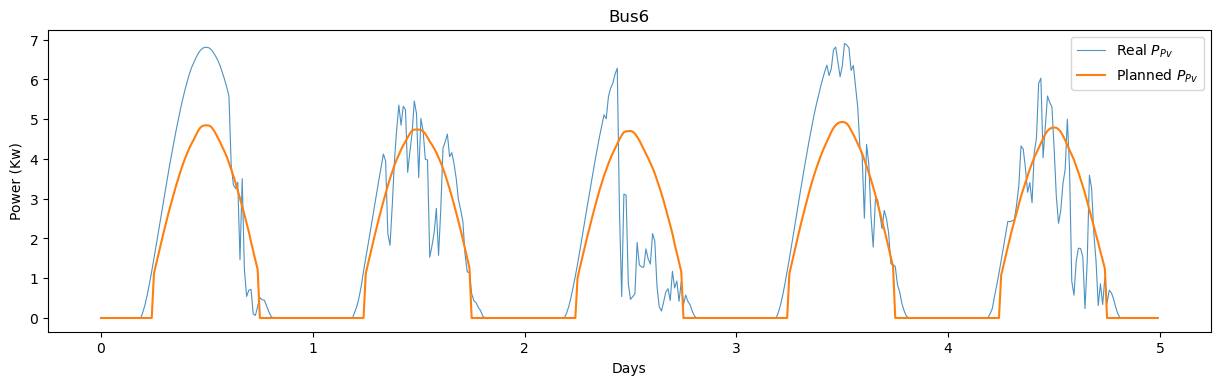

In [46]:
cur_bus = 6
fig, axx = plt.subplots(1,figsize=(15,4),dpi=100,sharex=True);
axx.plot(p_pv[cur_bus]*s_base/1000, label='Real $P_{Pv}$', lw=0.8, alpha=0.8,);
axx.plot(p_pv_plan[cur_bus]*s_base/1000,label='Planned $P_{Pv}$')
axx.set(title='Bus '+str(cur_bus), ylabel='Power(kw)')
axx.legend()
plt.xticks(range(0,(len(p_pv_plan[cur_bus])*mean_freq+probVar.Δt)//probVar.Δt, fullDay_min//probVar.Δt), labels=range(0,nb_day2_load+1) );

axx.set(xlabel='Days', ylabel='Power (Kw)', title = 'Bus'+str(cur_bus));


### Plot the actual and the planned $P_{pv}$ for a particular day


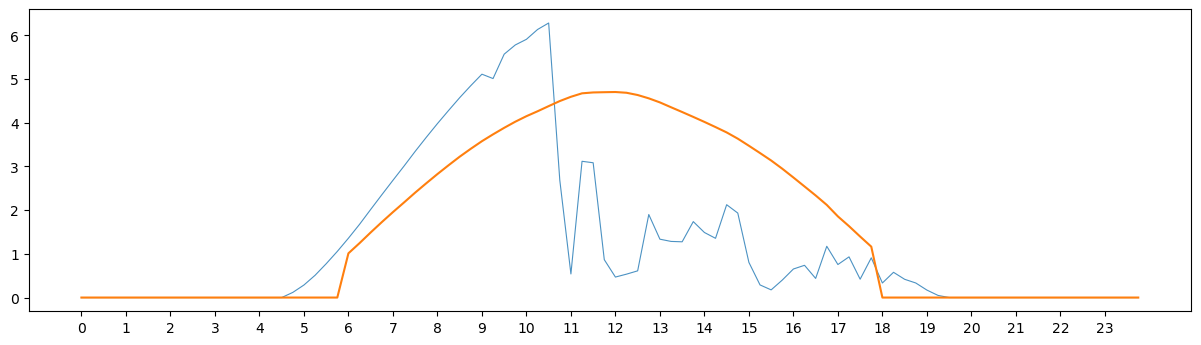

In [53]:
day2plot = 2 
d1, d2 = probVar.per_day*2, probVar.per_day*3
plt.subplots(1,figsize=(15,4),dpi=100,sharex=True);
plt.plot(p_pv[cur_bus][d1:d2]*s_base/1000, label='Real $P_{Pv}$', lw=0.8, alpha=0.8,);
plt.plot(p_pv_plan[cur_bus][d1:d2]*s_base/1000,label='Planned $P_{Pv}$')
plt.xticks(range(0,96,4), labels=range(0,24));
axx.set(xlabel='Days', ylabel='Power (Kw)', title = 'Bus'+str(cur_bus));


## Load demand

### Load Profiles Input and generate forecasted Load Data

In [65]:
# Reading Load Profiles
p_load = {}

# update cust_id using the load dict elm 
custs_id = list(data_custid_load_dict.keys())

p_load_plan = {} 

sizz = len(custs_id)

# We are using Pecan street user data in the IEEE network. Since there is more users in the IEEE network 
# than in the PecanStreet dataset, we duplicate some of them
for i in range(len(load_data_df)):
    p_load.update({load_data_df.loc[i]['Bus']: data_custid_load_dict[custs_id[i%sizz]].values*1000/s_base})
    
    
# Generating Planned Load data 
p_load_plan = {}
avr_freq = 15 # Averaging frequency in minutes. Make sure the averaging frequency is >= probVar.Δt

for elm in p_load:
    
    lst = p_load[elm]
    load_values = np.zeros((len(lst)));
    
    n = avr_freq//probVar.Δt # 15 minutes avg. 
                       
    for j in range(0,len(lst),n): 
        load_values[j:j+n] = np.mean(lst[j:j+n])

    # Planned Load 
    p_load_plan.update({elm: load_values})

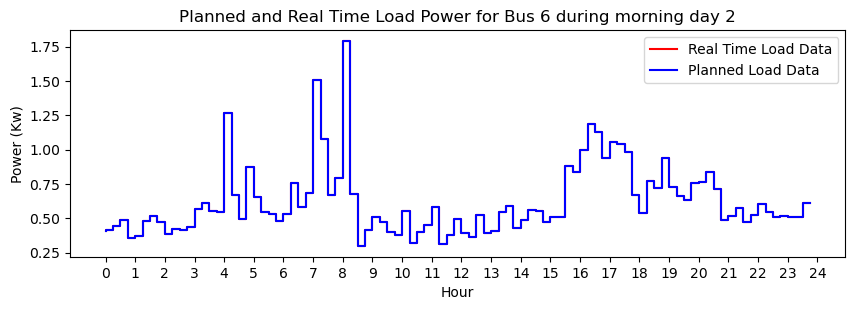

In [66]:
#Plotting Planned and Realtime Load data for bus 2
plt.figure(figsize=(10,3), dpi= 100, facecolor='w', edgecolor='k')
lim_plot0 = day2_min//probVar.Δt
lim_plot1 = (1440 + int(day2_min) )//probVar.Δt
plt.step(p_load[6][lim_plot0:lim_plot1]*s_base/1000, 'r-',)
plt.step(p_load_plan[6][lim_plot0:lim_plot1]*s_base/1000, 'b-')

plt.legend(['Real Time Load Data', 'Planned Load Data'], loc='best')
plt.title('Planned and Real Time Load Power for Bus 6 during morning day 2')
# plt.xticks(range(0,lim_plot1,int(60/ΔT)),)
plt.xticks(range(0, int((fullDay_min + probVar.Δt)//probVar.Δt),60//probVar.Δt), range(0,25));
plt.xlabel('Hour')
plt.ylabel('Power (Kw)');
# 

## EVs Data

In [84]:
# Read Ev_DATA dataframe and update its location in the probVar file so that all the other module access
# the file loaded in the main i.e. here 

# probVar_update.read_EV_df("./DataFiles/EVs_Data_5.csv")  # File 55 EVs 
# probVar_update.read_EV_df("./DataFiles/EVs_Data_6.csv")  # file 14 EVs
# probVar_update.read_EV_df("../DataFiles/EVsData/EVs_Data_5_1.csv")  # file 1 EV
probVar_update.read_EV_df("../DataFiles/EVsData/EVs_Data_5_reduced3.csv")  # file 2 EV


# load file that consists  of the  EV_number and associated bus number 
evs_data_df = probVar.evs_data_df

Ev_data_dataframe updated with the NEW file located at ../DataFiles/EVsData/EVs_Data_5_reduced3.csv


## Generate EVs arrival,departure time at home and malt

In [85]:
# create a lambda function to generate random departure and arrival time
rand_hour = lambda hour,nb_pts : np.round(np.random.normal(loc=hour,scale=100/probVar.Δt,size=nb_pts), decimals=0)

tot_bldg = len(load_data_df) # Total number of active buildings or users in the network

# Define some parameter for arival and departure at home and at work
min_dep = 6*60/probVar.Δt                # mn : Minimum departure time from home 6 Am 
mean_dep = 7*60/probVar.Δt               # mn : Mean departure hour,   from home 7 am
max_dep = 8*60/probVar.Δt                # mn : Maximum departure time from home 8 Am 

min_arr = 17*60/probVar.Δt               # mn : Minimum arrival time at home day 5 pm
mean_arr = 18*60/probVar.Δt              # mn : Mean arrival hour, 6 pm
max_arr = 20*60/probVar.Δt               # mn : Maximum arrival time at home day 8 pm

min_arr_work = 9.75*60/probVar.Δt        # mn : Minimum arrival hour, 9:45 am     
mean_arr_work = 10.5*60/probVar.Δt       # mn : Mean arrival hour, 10:30 am
max_arr_work = 10.75*60/probVar.Δt       # mn : Maximum departure hour, 10:45 am     

min_dep_work = 11*60/probVar.Δt          # mn : Minimum arrival hour, 11:00 am
mean_dep_work = 12*60/probVar.Δt        # mn : Mean arrival hour, 12:00 pm
max_dep_work = 13*60/probVar.Δt          # mn : Maximum arrival hour, 01:00 pm

# Create a dictionnary to hold all the precedent defined variables 
arrDep_dict = {'min_dep':min_dep, 'mean_dep': mean_dep, 'max_dep': max_dep, 
               'min_arr':min_arr, 'mean_arr':mean_arr, 'max_arr':max_arr,
               'min_arr_work':min_arr_work, 'mean_arr_work':mean_arr_work, 'max_arr_work':max_arr_work, 
               'min_dep_work':min_dep_work, 'mean_dep_work':mean_dep_work, 'max_dep_work':max_dep_work}


nb_sim_days = 3# Total number of simulation days

# Define number of arrival and departure for each day. 
# Case 1 : No charging at malt ==> dayly_nb_arr = 2 , dayly_nb_dep = 1 
# Case 2 :    Charging at malt ==> dayly_nb_arr = 3 , dayly_nb_dep = 2
nb_arr_daily = 3
nb_dep_daily = 2


# Total number of arrival and departure to consider in the simulation 
nb_arr_dep = nb_arr_daily + (nb_sim_days-1)*nb_dep_daily 


# chrg_at_malt = True goes with case 1 variables
# chrg_at_malt = False goes with case 2 variables
# Fill departure and arrival period
arr_dict, dep_dict =  brp.init_arrDep_instants(nb_sim_days,  nb_arr_dep, tot_bldg,
                                               arrDep_dict, chrg_at_work=True)

soc_arr_dict = {}
# Seting soc and soh at the beginning of the simulation and at arrival time of each day
for i in range(1, nb_arr_dep+1):
    soc_arr_dict.update({i: np.minimum(soc_max_arr, 
                                np.maximum(soc_min, np.random.normal(loc=0.3,scale=0.2,size=tot_bldg)))})
# Initialise Soh
soh_arr = np.minimum(soc_max_arr, np.maximum(soc_min, np.random.normal(loc=0.8,scale=0.1,size=tot_bldg)) )


#A dictionary of EVs parameters for EV conected to each load bus
ev_data = brp.init_evDataParams(arr_dict, dep_dict, soc_arr_dict, soh_arr, 
                                evs_data_df, nb_arr_dep )

### Generate Ev_consumption

In [86]:
p_ev = {}             # Intermediate dict variable
p_ev_dumb_dict = {}   # Dumb charging dict
p_ev_charBin = {}     # Binary Dictionary of ev_charging. Equals 1 and 0 when the ev is respectively conected and disconnected

# Generating Planned EVs Consumption data             
p_ev_plan = {} 

for i in range(len(evs_data_df)):# for each electrical vehicle 
    var_len = len(p_pv[list(p_pv.keys())[0]]) # Get the len of the first elm in dict p_pv
    p_ev.update({evs_data_df['Bus'][i]: np.zeros((var_len, )) })# Create an array to store ev_data
                                                                # for all the considered bus 
    ev_params_cur_bus = ev_data[evs_data_df['Bus'][i]]          # Get the parameters of the ev on the current bus 
    
    chrgBin = {} # Intermediate variable to store the binary charging variable for each interval
    
    # for each minute of the considered period, starting from the beginning of the second day (simulation starting instant)
    var1  = np.arange(len(p_pv[15][probVar.day2_min//probVar.Δt:])) 
    
    # cur_arr_dep_ind = 1 ==> Set to 1 all the instants where the ev in connected over the interval
    #                                                          delimited by [t_arr1 t_dep1]
    AA = var1 < ev_params_cur_bus['t_dep1'] #AA is a Binary variable such as **************----------------------
                                            # where * = 1 and - = 0 
    
    # cur_arr_dep_ind = 2,.... nb_arr_dep+1  ==> Set to 1 all the instants where the ev in connected over the interval
    # delimited by [t_arr(i) t_dep(i)]
    for cur_arr_dep_ind in range(2, nb_arr_dep+1):
        t_arr = 't_arr'+str(cur_arr_dep_ind)
        t_dep = 't_dep'+str(cur_arr_dep_ind)
        # Find particular instants where the Ev is connected over the cur_arr_dep_ind (interval) 
        # ----------*************************    var1 >= ev_params_cur_bus[t_arr]
        # ****************-------------------    var1 < ev_params_cur_bus[t_dep]
        # ----------******-------------------    var2
        var2 = (var1 >= ev_params_cur_bus[t_arr]) & (var1 < ev_params_cur_bus[t_dep])
        chrgBin.update({cur_arr_dep_ind: var2})
        
    var3  = np.zeros((len(AA), ),dtype=int)
    # Produce an unique array where the interval delimited by each [t_arr(j) t_dep(j)] are set 1 such that 
    #                  [t_arr2, t_dep2[           [t_arr3, t_dep3[                     ..
    # var3 = ----------****************-----------****************---------------------...
    for elm in chrgBin.keys():
        var3 = var3 | chrgBin[elm]
        
    # Add the interval delimited by the [t_arr1, t_dep1[
    #        [t_arr1, t_dep1[          [t_arr2, t_dep2[           [t_arr3, t_dep3[    ..
    # var3 = ****************----------****************-----------****************--------
    var3 = var3 | AA

    for j in range(1, nb_arr_dep+1):
        soc = 'soc_arr'+ str(j)
        t_dep = 't_dep' + str(j)
        t_arr = 't_arr' + str(j)

        # Compute the dumb strategy charging for each period of time delimited by  [t_arr(j), t_dep(j)[
        pev_int = (1/eff_chrg)*60*(e_bat*(soc_min_dep - ev_params_cur_bus[soc])/(ev_params_cur_bus[t_dep] -
                                                                    ev_params_cur_bus[t_arr] ))/(1000*probVar.Δt)
        p_ev_dumb_dict.update({j: pev_int}) # Update dict with p_ev over each interval 
        
    # Set the charging power for each interval to the maximum power allowed being p_max
    p_ev[evs_data_df['Bus'][i]][probVar.day2_min//probVar.Δt:][AA] = (min(p_ev_dumb_dict[1], p_max))*1000/s_base # Interval 1 
    for j in range(2, nb_arr_dep+1):
        p_ev[evs_data_df['Bus'][i]][probVar.day2_min//probVar.Δt:][chrgBin[j]] = (min(p_ev_dumb_dict[j], p_max))*1000/s_base

    
    # Fill the active and reactive power data for the current EV
    p_ev_plan.update({evs_data_df['Bus'][i]: p_ev[evs_data_df['Bus'][i]][probVar.day2_min//probVar.Δt:]}) 
    load_values_df = pd.DataFrame(p_ev[evs_data_df['Bus'][i]][probVar.day2_min//probVar.Δt:])
    #q_ev_plan.update({evs_data_df['Bus'][i]: (load_values_df[0]* math.tan(math.acos(1))).tolist()})
    
    # Store the binary variable for each EV
    p_ev_charBin.update({evs_data_df['Bus'][i]: var3})

### Show arrival and departure instant

In [88]:
for elm in range(1,nb_arr_dep+1):
    brp.printArrDep_time(ev_data,'t_arr'+str(elm), 't_dep'+str(elm),5)
    print()

  	 	      t_arr1,     t_dep1
   	 	    ----------------------
Ev on bus: 106 :  ['0D: 0h0', '0D: 8h0']
Ev on bus: 203 :  ['0D: 0h0', '0D: 6h0']

  	 	      t_arr2,     t_dep2
   	 	    ----------------------
Ev on bus: 106 :  ['0D: 10h15', '0D: 11h30']
Ev on bus: 203 :  ['0D: 10h45', '0D: 11h0']

  	 	      t_arr3,     t_dep3
   	 	    ----------------------
Ev on bus: 106 :  ['0D: 19h30', '1D: 6h0']
Ev on bus: 203 :  ['0D: 17h0', '1D: 6h0']

  	 	      t_arr4,     t_dep4
   	 	    ----------------------
Ev on bus: 106 :  ['1D: 10h45', '1D: 12h15']
Ev on bus: 203 :  ['1D: 10h45', '1D: 11h0']

  	 	      t_arr5,     t_dep5
   	 	    ----------------------
Ev on bus: 106 :  ['1D: 18h0', '2D: 6h30']
Ev on bus: 203 :  ['1D: 17h0', '2D: 8h0']

  	 	      t_arr6,     t_dep6
   	 	    ----------------------
Ev on bus: 106 :  ['2D: 10h45', '2D: 12h45']
Ev on bus: 203 :  ['2D: 10h45', '2D: 13h0']

  	 	      t_arr7,     t_dep7
   	 	    ----------------------
Ev on bus: 106 :  ['2D: 17h0', '3D

#### Plot Ev consumption for one bus

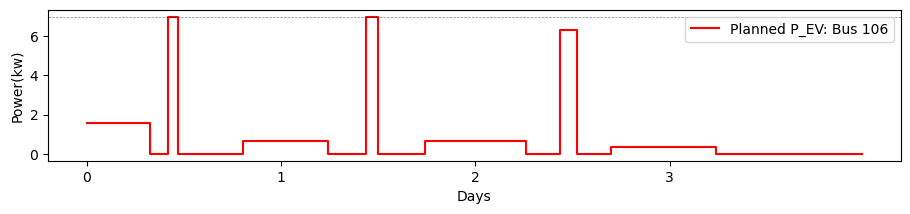

In [91]:
cur_bus = list(ev_data.keys())
#Plotting Planned EV data for a bus
plt.figure(figsize=(11,2), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(p_ev_plan[cur_bus[0]]*s_base/1000, 'r',ds='steps' )
# plt.plot(p_ev_plan[cur_bus[1]]*s_base/1000, 'b',ds='steps')
plt.axhline(7, color='k', lw=0.5,ls='--', alpha=0.5)

# plt.plot(p_ev_plan[cur_bus]*s_base/1000, 'r', q_ev_plan[cur_bus], 'b-')
# plt.legend([f'Planned P_EV: Bus {cur_bus[0]}', f'Planned PEV: Bus {cur_bus[1]}'], loc='best')
plt.legend([f'Planned P_EV: Bus {cur_bus[0]}'], loc='best')
plt.xticks(range(0,5000//probVar.Δt,1444//probVar.Δt),labels=range(0,4));
plt.xlabel('Days');
plt.ylabel('Power(kw)');
# plt.savefig('evv.pdf')

## Generate P_plan

In [99]:
# Planned BRP power for each settlement period
p_plan = brp.compute_Pplan(p_pv_plan, p_load_plan, p_ev_plan )

### Load Dumb Energy mismatch of previous day

In [101]:
# load new file
a_file = open('../DataFiles/Em_dumb.pkl', "rb")
emis_dumb_df = pickle.load(a_file)

# MPC 
See the pdf file [ProblemFormulation]()


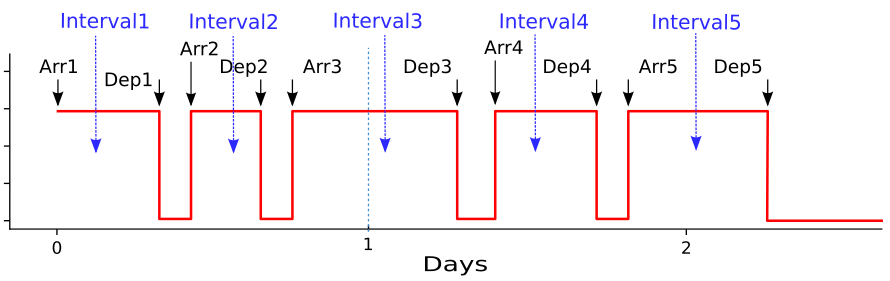

## Creating variables to store simulation result for each instant

In [102]:
# define variables for MPC problems
# nb_sim_days = 1 
hor_in_min = probVar.hor_dict['15mn'] # Define the MPC horizon in minutes
hor = hor_in_min // probVar.Δt         # Redefine the horizon in number of Δt  period to consider
t_sim = nb_sim_days*probVar.fullDay_min//probVar.Δt      #Total duration of the study(in minutes)


# Create all the needed  variables  over the problem horizon
activePower_var, storage_var, network_var = brp.create_probvar(t_sim, len(bus_df), ev_data) 

# unpack variables
p_ev_chrg_prob, del_p_ev_prob, p_bus_prob, p_gen_prob = activePower_var
soc_prob, soc_pred_ins, soh_prob  = storage_var
theta_prob, voltage_prob = network_var

# Additional variables
saved_cost, zero_to_k_Emis, norm_coef_list, var_soc_list, var_imb_list = [],[],[],[],[]


# Variables used for the P_pv prediction in MPC
hour_back_windows = 1  # Backward windows in hours
hour_frcst_freq = 1    # Updating frequency in  hours
prev_day_type = 0      # Starting regime 
scale = 150            # Scaling factor of irradiance in power

# Pack input for regime switching Pv_pred in MPC
pred_input = hor_in_min, hour_back_windows, hour_frcst_freq, extracted_date, saving_folder_file, prev_day_type, scale

# Define alpha
α = 0.

## Run MPC 

In [133]:
for k in tqdm(range(0, t_sim)):
    
    # #####################----------------------   Variable over the MPC horizon   ---------------------------###################
    activePower_var, storage_var, network_var = mpc.createOptim_var(hor, len(bus_df)) # Create all the needed variables

    # create all  variables needed over the MPC horizon  
    p_ev_chrg_hor, del_p_ev_hor, p_pv_hor_dict, p_load_hor_dict, p_bus, p_gen = activePower_var
    soc_hor, soc_relax, soh_hor = storage_var 
    theta, voltage = network_var
    
    # #####################------------------------------      CONSTRAINTS     ---------------------------###################
    # list to store constraints
    line_constraints = [] #Line flow constraints list
    bus_constraints = [] #bus constraints list
    vehicle_constraints = [] #vehicle constraints list
    
    ##----------   Bus constraints -------------------------------------------------------------------------------------------
    for bus_nbr in range(1,len(G)): # for all the bus in the network 
#     for i in range(1,8): # for all the bus in the network 
        bus_constraints,  p_pv_hor_dict , p_load_hor_dict = mpc.fill_busConstraints(k, bus_nbr, hor, p_pv, p_load, 
                                                                                    p_pv_hor_dict, p_load_hor_dict,
                                                                                    bus_constraints, p_bus,
                                                                                    p_ev_chrg_hor, 
                                                                                    pv_pred_type='rgSwitch', pred_input=pred_input)
    # Voltage limits (5%)
    bus_constraints.append(cp.abs((1-voltage)*100) <= voltage_tolerance)
    
    #Bus 0 is considered as generator bus 
    bus_constraints.append(p_bus[0,:] == p_gen[0,:]) 

    #Initial values for generator bus 
    bus_constraints.append(voltage[0,:] == nom_voltage/v_base_sec)
    bus_constraints.append(theta[0,:] == 0)

    ##----------  Line Constraints -------------------------------------------------------------------------------------------
    line_constraints = mpc.fill_lineConstraints(line_constraints, B, G, 
                                                theta, voltage, p_bus, 
                                                pbus_bound= 0., conLinPower_bound=5.)

    ##----------  Vehicle Constraints -------------------------------------------------------------------------------------------
    vehicle_constraints, relax_list  = mpc.fill_vehConstraints(k, hor, vehicle_constraints,
                                                  (p_ev_plan, p_ev_chrg_hor, del_p_ev_hor, p_ev_charBin),
                                                  (soc_prob, soc_hor, soc_relax),
                                                  (soh_prob, soh_hor),  
                                                   ev_data )
    
    # #####################----------------------   Cost to optimize   ---------------------------###################
    E_mis, E_mis_T_init = mpc.prob_imbalancePer_Emis(k,hor, len(bus_df), p_plan, 
                                                     p_pv_hor_dict, p_load_hor_dict, p_ev_chrg_hor, zero_to_k_Emis)

    norm_coef_E_mis = brp.dumb_en_mis_at(k, hor_in_min, emis_dumb_df) # get the energy mismatch over the MPC horizon's for all 
                                                                      # previous day starting from instant k using the dumb strategy
    

    # Construct Total coptimization cost
    # Hstack transform the relax_list in a vector since cp. max does not accept a list as argument
    total_cost =  α*cp.max(cp.hstack(relax_list)) + (1-α)*cp.sum(E_mis)/norm_coef_E_mis
#     total_cost =  α*(cp.sum(relax_list)/len(relax_list)) + (1-α)*cp.sum(E_mis)/norm_coef_E_mis

    #--------------------------------------------------------------------------------------------------------
     # Constructing Complete constraints
    constraints =  bus_constraints + vehicle_constraints #Concatenating all constraints 
    
    # #####################----------------------  Problem solving  ------------------------###################
    prob = mpc.solve_prob(total_cost, constraints, (cp.MOSEK, cp.GUROBI) )
    
    if prob.status != 'optimal': # print instant where problem status is not optimal
        print("-------***** Time k = ",k, '- Hor = ', hor*probVar.Δt,  "Mn  ==> Problem status :", prob.status,"****-----")

    
    # #####################----------------------  Saving optimisation result  ------------------------###################
    var_soc_list.append( α*(cp.sum(relax_list)/len(relax_list)).value)
    var_imb_list.append( (1-α)*(cp.sum(E_mis)/norm_coef_E_mis).value )

    # save the optimization result for the current instant k
    for cur_bus in evs_data_df['Bus'].values:
        
        soc_updating_state = mpc.init_EvArrival_soc(k, ev_data[cur_bus], soc_prob[cur_bus]) # initialize ev_soc at next instant if needed
            
        mpc.init_Ev_soc(k, soc_updating_state, brp.interval_finder(k,ev_data[cur_bus])[0], 
                        (soc_prob[cur_bus], soc_hor[cur_bus]) ) # If SoC not updated yet for the next loop excecution do it using the opt result 
                                                                # or soc_min when not connected  to the grid
        soh_prob[cur_bus][0,k+1:k+2] = soh_hor[cur_bus].value[0,1:2]
        p_ev_chrg_prob[cur_bus][0,k:k+1] = p_ev_chrg_hor[cur_bus].value[0,:1] 

    for elm in range(len(bus_df)+1):
        theta_prob[elm][k:k+sld_freq], voltage_prob[elm][k:k+sld_freq] = theta[elm][:sld_freq].value, voltage[elm][:sld_freq].value
        p_bus_prob[elm][k:k+ sld_freq]= p_bus[elm][:sld_freq].value

    # Save the energy mismatch at time k (initial instant of the initial imbalance period)
    zero_to_k_Emis.append(E_mis_T_init[0].value)



100%|##########| 288/288 [03:32<00:00,  1.36it/s]


### 

In [105]:
####  Compute dumb strategy soc
soc_prob_dumb = brp.compute_DumbSoc(p_ev_plan, ev_data, t_sim)


# Create an array such that 
# pplan_delt = [p_plan[0],p_plan[0] ... p_plan[0], p_plan[1],p_plan[1] ... p_plan[1], ...,  p_plan[-1],p_plan[-1] ... p_plan[-1]]
# the number of time an element repeats is ΔT
pplan_delt = np.kron(p_plan, np.ones((ΔT,)) )

day_2_imba = day2_min//Δt     # Number of the first imbalance period of day 2
day_last_imba = fullDay_min*(nb_sim_days+1)//Δt

pload_pv = 0 
for elm in p_load:
    pload_pv = pload_pv  + p_pv[elm] - p_load[elm][:len(p_pv[elm])]

p_EV_char = 0 
for elm in p_ev_chrg_prob:
    p_EV_char = p_EV_char + p_ev_chrg_prob[elm][0,] 

p_EV_char_dumb = 0 
for elm in p_ev_chrg_prob:
    p_EV_char_dumb = p_EV_char_dumb + p_ev_plan[elm][:nb_sim_days*day_2_imba]

    

### Plot Energy mismatch

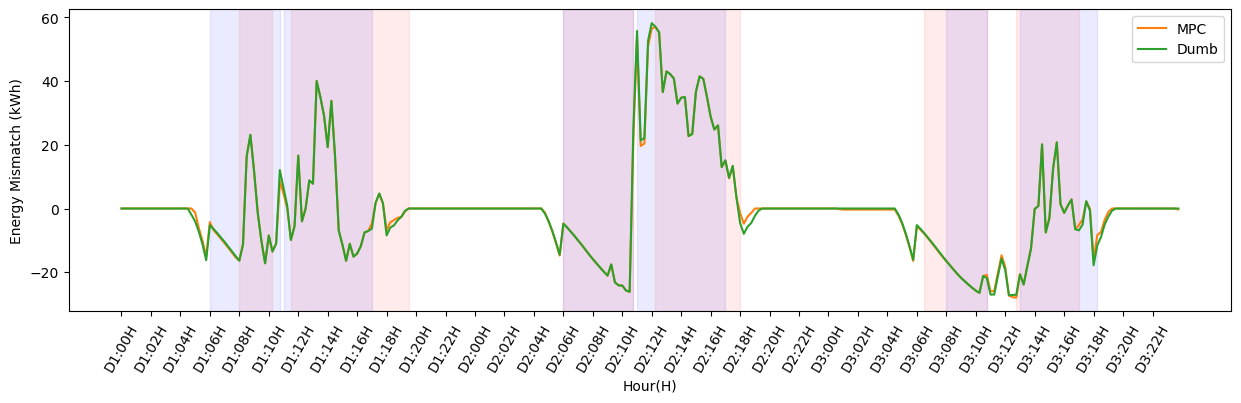

In [115]:
def colorUnpluggedPeriod():
    for cur_bus ,indx in zip(ev_data,range(len(ev_data))):
        for cur_int in range(1, nb_arr_dep):
            dep = ev_data[cur_bus]['t_dep'+str(cur_int)]/ΔT
            arr = ev_data[cur_bus]['t_arr'+str(cur_int+1)]/ΔT  
            plt.axvspan(dep,arr,color=col[indx],alpha=0.08)

r1 = np.kron(np.ones((nb_sim_days), dtype=int), np.arange(0,24,2))
r2 = np.kron( np.arange(1,nb_sim_days+1),np.ones((np.arange(0,24,2).shape[0]),dtype=int))
labells = [f'D{Day}:{hour:>02}H' for Day,hour in zip(r2,r1)]

kwargs = (dict(label='MPC',color='tab:orange'),dict(label='Dumb',color='tab:green'))

dumb_mis = pplan_delt[:nb_sim_days*day_2_imba] - (pload_pv[day_2_imba:day_last_imba] - p_EV_char_dumb)*s_base/1000
dumb_mis = Δt*np.sum(np.reshape(dumb_mis,(-1,ΔT)),axis=1)/60
mpc_mis = np.sum(np.reshape(zero_to_k_Emis,(-1,ΔT)),axis=1)

plt.figure(figsize=(15,4), dpi=100)
col = ['r', 'b']
plt.plot(mpc_mis,**kwargs[0] )
plt.plot(dumb_mis, **kwargs[1])
# plt.plot(abs(np.sum(np.reshape(zero_to_k_Emis,(-1,ΔT)),axis=1)))
# plt.xticks(range(0,nb_sim_days*96,4), labels=range(0,nb_sim_days*24));
plt.xticks(range(0,nb_sim_days*96,8), labels=labells, rotation=60);
colorUnpluggedPeriod()

            
plt.ylabel('Energy Mismatch (kWh)')
plt.xlabel('Hour(H)');
plt.legend();


### Print Energy Mismatch during the simulation

In [126]:
print(f'MPC Energy mismatch :  {np.round(sum(abs(mpc_mis)),decimals=2)} kWh')
print(f'Dumb Energy mismatch:  {np.round(sum(abs(dumb_mis)),decimals=2)} kWh')


MPC Energy mismatch :  2702.62 kWh
Dumb Energy mismatch:  2760.23 kWh


### Plot SOc of connected Evs

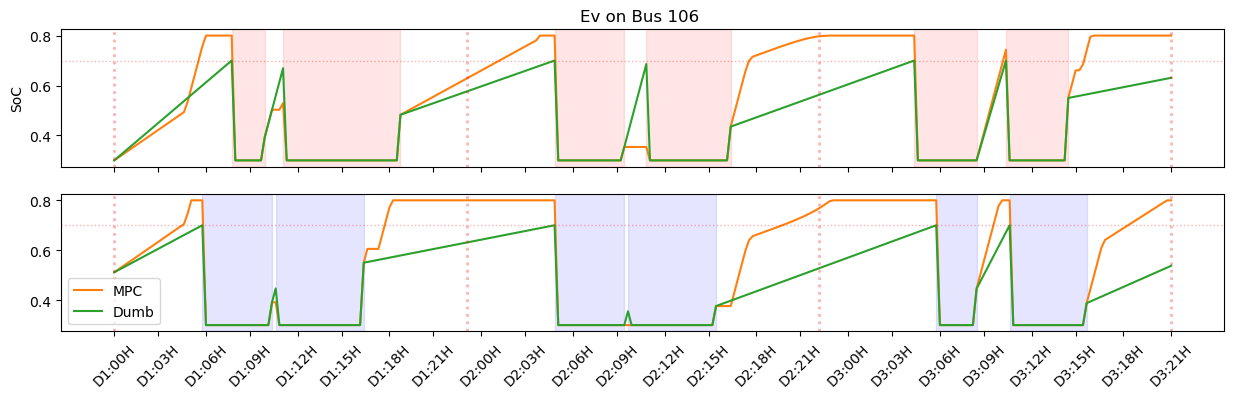

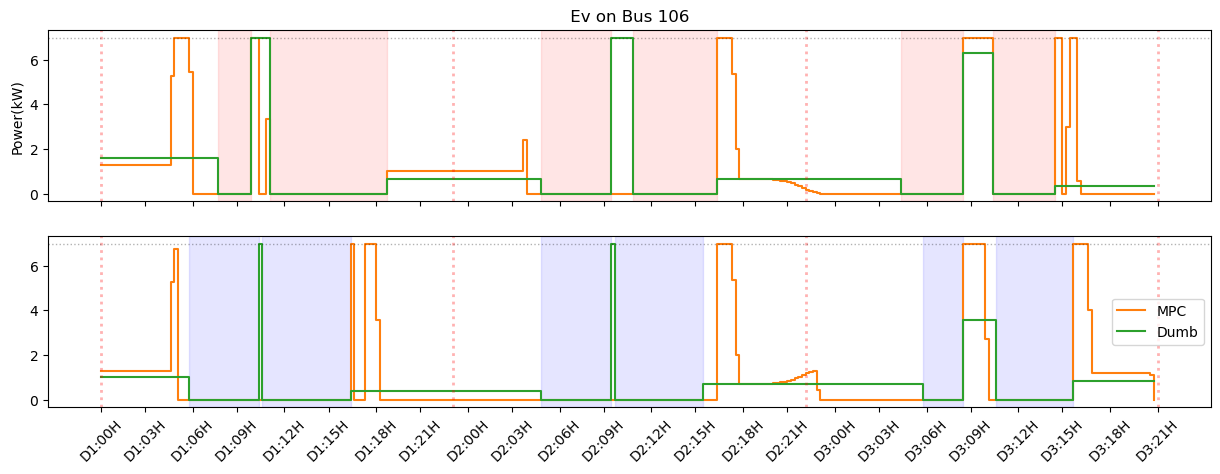

In [109]:
# nb_sim_days = 1
r1 = np.kron(np.ones((nb_sim_days), dtype=int), np.arange(0,24,nb_sim_days))
r2 = np.kron( np.arange(1,nb_sim_days+1),np.ones((np.arange(0,24,nb_sim_days).shape[0]),dtype=int))
labells = [f'D{Day}:{hour:>02}H' for Day,hour in zip(r2,r1)]
per_day = 1440//Δt

in_ticks = np.linspace(0,nb_sim_days*per_day,24, dtype=int)

leng = 15 

fig, axx = plt.subplots(2,1,figsize=(leng,4), dpi=100, sharex=True)

for axis,cur_bus ,indx in zip(axx.flatten(), ev_data, range(len(ev_data))):
    axis.plot(soc_prob[cur_bus][0,],**kwargs[0]);
    axis.plot(soc_prob_dumb[cur_bus], **kwargs[1]);
    axis.axhline(0.7, color='r', ls=':', lw=1, alpha=0.3)# Set a line at 
    
    for cur_int in range(1,nb_arr_dep):
        dep = ev_data[cur_bus]['t_dep'+str(cur_int)]
        arr = ev_data[cur_bus]['t_arr'+str(cur_int+1)] 
        axis.axvspan(dep,arr,color=col[indx],alpha=0.1)
   
    # COlor starting of each day    
    for cur_day in range(nb_sim_days+1):
        axis.axvline(per_day*cur_day, color='r', ls=':', lw=2, alpha=0.3)# Set a line at 
        
plt.xticks(in_ticks, labels=labells,rotation=45)
var = evs_data_df['Bus']
axx[0].set(ylabel='SoC',title=f'Ev on Bus {var[0]} ');
# axx[1].set(ylabel='SoC',title= f'Ev on Bus {var[1]}');
plt.legend(['MPC', 'Dumb']);


fig, axx = plt.subplots(2,1,figsize=(leng,5), dpi=100, sharex=True)
for axis, cur_bus,indx in zip(axx.flatten(), ev_data, range(len(ev_data))):
    axis.plot(p_ev_chrg_prob[cur_bus][0,:t_sim]*s_base/1000,ds='steps-post',**kwargs[0]);
    axis.plot(p_ev_plan[cur_bus][:t_sim]*s_base/1000,ds='steps-post',**kwargs[1]);
#     axis.plot(list(soc_prob_dumb.items())[indx][1].T,);
    
    for cur_int in range(1,nb_arr_dep):
        dep = ev_data[cur_bus]['t_dep'+str(cur_int)]
        arr = ev_data[cur_bus]['t_arr'+str(cur_int+1)] 
        axis.axvspan(dep,arr,color=col[indx],alpha=0.1)
        
    # COlor starting of each day    
    for cur_day in range(nb_sim_days+1):
        axis.axvline(per_day*cur_day, color='r', ls=':', lw=2, alpha=0.3)# Set a line at 
        
    axis.axhline(p_max, color='k', ls=':', lw=1, alpha=0.3)# Set a line at 
        
plt.xticks(in_ticks,labels=labells,rotation=45)
axx[0].set(ylabel='Power(kW)',title=' Ev on Bus 106 ');
# axx[1].set(ylabel='Power(kW)',title=' Ev on Bus 203 ');
plt.legend(['MPC', 'Dumb']);


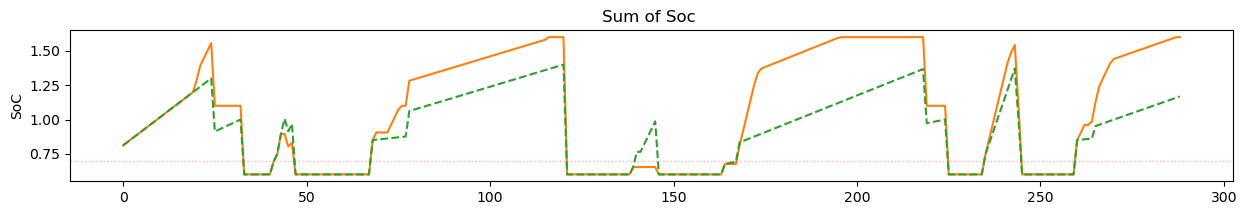

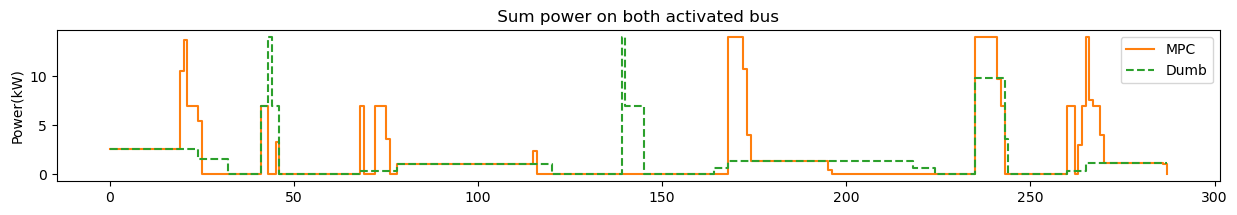

In [113]:
# nb_sim_days = 1

soc_sum_mpc = np.zeros(t_sim+1)
soc_sum_dumb = np.zeros(t_sim+1)
p_ev_sum_mpc = np.zeros(t_sim)
p_ev_sum_dumb = np.zeros(t_sim)

r1 = np.kron(np.ones((nb_sim_days), dtype=int), np.arange(0,24,nb_sim_days))
r2 = np.kron( np.arange(1,nb_sim_days+1),np.ones((np.arange(0,24,nb_sim_days).shape[0]),dtype=int))
labells = [f'D{Day}:{hour:>02}H' for Day,hour in zip(r2,r1)]
per_day = 1440//Δt
leng = 15 


fig, axx = plt.subplots(1,1,figsize=(leng,2), dpi=100, sharex=True)
for cur_bus in ev_data:
    soc_sum_mpc = soc_sum_mpc + soc_prob[cur_bus][0,]
    soc_sum_dumb = soc_sum_dumb + soc_prob_dumb[cur_bus]
    
# colorUnpluggedPeriod()

axx.plot(soc_sum_mpc,**kwargs[0]);
axx.plot(soc_sum_dumb,ls='--', **kwargs[1]);
axx.axhline(0.7, color='r', ls=':', lw=1, alpha=0.3)# Set a line at 
# plt.xticks(range(0,nb_sim_days*per_day,nb_sim_days*4),labels=labells,rotation=45)
axx.set(ylabel='SoC',title=f'Sum of Soc ');


fig, axx = plt.subplots(1,1,figsize=(leng,2), dpi=100, sharex=True)
for cur_bus in ev_data:
    p_ev_sum_mpc += p_ev_chrg_prob[cur_bus][0,:t_sim]
    p_ev_sum_dumb += p_ev_plan[cur_bus][:t_sim]

# colorUnpluggedPeriod()

axx.plot(p_ev_sum_mpc*s_base/1000,ds='steps-post',**kwargs[0]);
axx.plot(p_ev_sum_dumb*s_base/1000,ls='--', ds='steps-post',**kwargs[1]);
# plt.xticks(range(0,nb_sim_days*per_day,nb_sim_days*4),labels=labells,rotation=45)
axx.set(ylabel='Power(kW)',title=' Sum power on both activated bus ');
plt.legend(['MPC', 'Dumb']);


### Plot Pplan, P_BRP without EV and P_BRP with EV

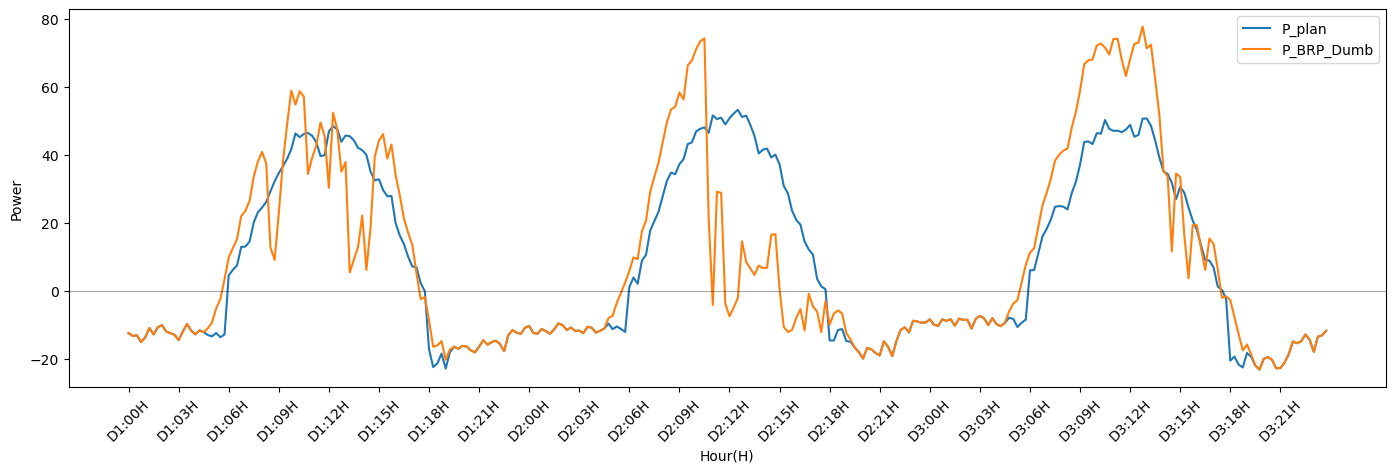

In [110]:
plt.figure(figsize=(17,5), dpi=100)
# colorUnpluggedPeriod()
plt.plot(pplan_delt[:nb_sim_days*day_2_imba]/4, label='P_plan',)
# plt.plot(pload_pv[day_2_imba:day_last_imba]*s_base/1000/4, label='P_BRP (No Ev)')
# plt.plot((pload_pv[day_2_imba:day_last_imba] - p_EV_char)*s_base/1000/4, label='P_BRP')
plt.plot((pload_pv[day_2_imba:day_last_imba] - p_EV_char_dumb)*s_base/1000/4, label='P_BRP_Dumb')

plt.axhline(y=0, color='k', alpha =0.5,lw=0.5)
plt.xticks(range(0,day_2_imba*nb_sim_days,nb_sim_days*60//Δt), labels=labells, rotation=45);

plt.legend();
plt.ylabel('Power')
plt.xlabel('Hour(H)');

### Zoom on a part of the previous figure

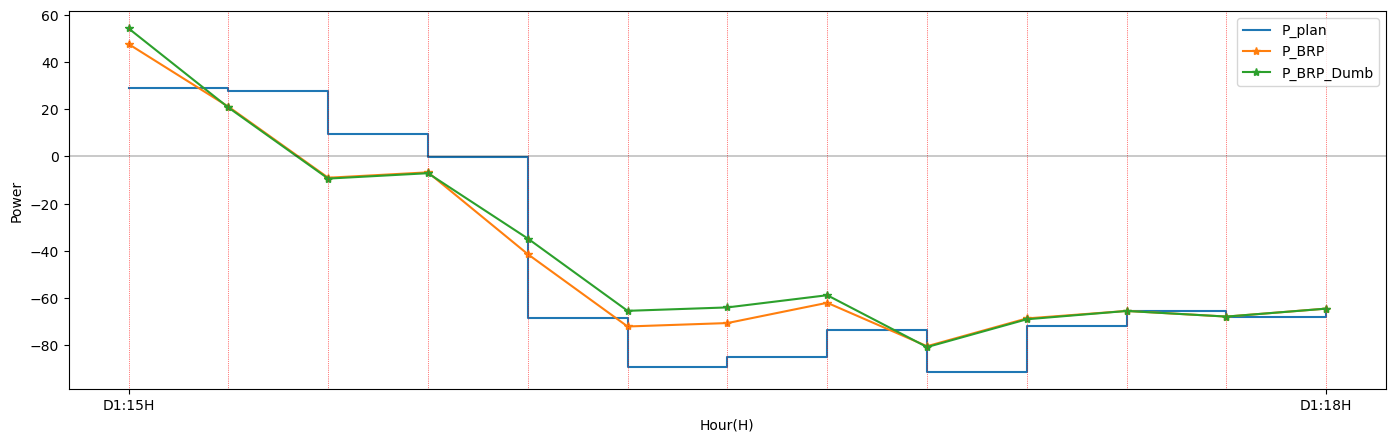

In [112]:
plt.figure(figsize=(17,5), dpi=100)

h1 = 17 # Starting hour to plot 
h2 = 20# Ending hour to plot 

h_start =  h1*(60//Δt)    # First 
h_end = h2*(60//Δt) + 1

plt.plot(pplan_delt[h_start:h_end], label='P_plan',ds='steps-post')
# plt.plot(pload_pv[h_start+day_2_imba:day_2_imba+h_end]*s_base/1000, label='P_BRP (No Ev)', marker='*')
plt.plot((pload_pv[h_start+day_2_imba:day_2_imba+h_end] - p_EV_char[h_start:h_end])*s_base/1000, label='P_BRP', marker='*',)
plt.plot((pload_pv[h_start+day_2_imba:day_2_imba+h_end] - p_EV_char_dumb[h_start:h_end])*s_base/1000, label='P_BRP_Dumb', marker='*',)

# aa = (pload_pv[h_start+day_2_imba:day_2_imba+h_end] - p_EV_char_dumb[h_start:h_end])*s_base/1000
# fl = np.reshape(aa[:-1],(-1,3)).mean(axis=1)
# plt.plot(np.kron(fl,np.ones(3)),color ='red',ds='steps-post')

plt.legend()
# # plt.xticks(range(0,h_end,60//Δt),labels=range(len(range(0,h_end,60//Δt))))
plt.xticks(range(0,h_end-h_start,60*nb_sim_days//Δt),labels=labells[h1//nb_sim_days:(h2//nb_sim_days)+1])

for ii in range(0,h_end-h_start,ΔT):
    plt.axvline(x=ii, color='red', lw=0.5, ls=':')
    
plt.axhline(0,color='k',lw=0.3)
    
# for indx in range(2):
#     dep = ev_data[list(ev_data.keys())[indx]]['t_dep1']
#     arr = ev_data[list(ev_data.keys())[indx]]['t_arr1']
#     plt.axvspan(dep,arr,color=col[indx],alpha=0.08,)


plt.ylabel('Power')
plt.xlabel('Hour(H)');
# plt.ylim((-30,-18))